In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Weekly Project: Image Classification with Transfer Learning

In this project, you will build a complete image classification pipeline using transfer learning. You'll work with the dataset provided by your instructor.

**Learning Objectives:**
- Load and prepare image datasets for deep learning
- Use pre-trained models for transfer learning
- Implement two transfer learning strategies: fine-tuning and feature extraction
- Evaluate model performance
- Deploy models using ONNX for production (Optional)

**References:**

- [Training with PyTorch](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html)
- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

## Table of Contents

1. [Data Ingestion](#1)
2. [Data Preparation](#2)
3. [Model Building](#3)
4. [Training](#4)
   - [4.1 ConvNet as Fixed Feature Extractor](#4-1)
   - [4.2 Fine-tuning the ConvNet](#4-2)
5. [Evaluation](#5)
6. [Inference on Custom Images](#6)
7. [Deployment (ONNX)](#7)

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lulu2324239","key":"6d5742a79ddbbe180ccbc5068ca33666"}'}

In [4]:
import os
import shutil

os.makedirs("/root/.kaggle", exist_ok=True)
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 0o600)


In [5]:
!kaggle datasets download -d puneet6060/intel-image-classification


Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 77% 268M/346M [00:02<00:00, 87.5MB/s]
100% 346M/346M [00:02<00:00, 129MB/s] 


In [6]:
!unzip intel-image-classification.zip -d data


Streaming output truncated to the last 5000 lines.
  inflating: data/seg_train/seg_train/mountain/7506.jpg  
  inflating: data/seg_train/seg_train/mountain/7537.jpg  
  inflating: data/seg_train/seg_train/mountain/7539.jpg  
  inflating: data/seg_train/seg_train/mountain/7551.jpg  
  inflating: data/seg_train/seg_train/mountain/7560.jpg  
  inflating: data/seg_train/seg_train/mountain/7565.jpg  
  inflating: data/seg_train/seg_train/mountain/7578.jpg  
  inflating: data/seg_train/seg_train/mountain/7581.jpg  
  inflating: data/seg_train/seg_train/mountain/7586.jpg  
  inflating: data/seg_train/seg_train/mountain/7647.jpg  
  inflating: data/seg_train/seg_train/mountain/7652.jpg  
  inflating: data/seg_train/seg_train/mountain/7654.jpg  
  inflating: data/seg_train/seg_train/mountain/7662.jpg  
  inflating: data/seg_train/seg_train/mountain/767.jpg  
  inflating: data/seg_train/seg_train/mountain/7672.jpg  
  inflating: data/seg_train/seg_train/mountain/7679.jpg  
  inflating: data/seg_

In [7]:
!ls data

seg_pred  seg_test  seg_train


## Imports

In [46]:
import torch
from torchvision import datasets
from torchvision import transforms
import os
import torch.nn as nn
from torchvision import models
import time
import copy
import matplotlib.pyplot as plt

## Setup Device

**Note: you will need a GPU; so please run this on Colab and specify a GPU runtime (e.g., T4-GPU)**

In [9]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


<a name='1'></a>
## 1. Data Ingestion

**Task**: The dataset should be downloaded and extracted to a local directory.

**References:**

- [Dataset and DataLoader](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#dataset-and-dataloader)
- [torchvision.datasets.ImageFolder](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html)

In [10]:
# YOUR CODE HERE
data_dir = "data"

train_dir = os.path.join(data_dir, "seg_train", "seg_train")
test_dir  = os.path.join(data_dir, "seg_test", "seg_test")

**Task**: create a `train_dataset` and `test_dataset` (without transforms for now).

In [11]:
# YOUR CODE HERE
train_dataset = datasets.ImageFolder(root=train_dir)
test_dataset  = datasets.ImageFolder(root=test_dir)

**Quick Check**: verify the counts of both train and test sets, match what's in the original source (Kaggle).

In [13]:
# YOUR CODE HERE
print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))
print("Classes:", train_dataset.classes)#14k+ for the train set and 3k+ for the test set (verified from kaggle)

Train samples: 14034
Test samples: 3000
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


<a name='2'></a>
## 2. Data Preparation

Before training, we need to:
1. Define augmentation for training
2. Define normalization for both training and testing
3. Create **`DataLoader`** for efficient batch processing

**Task:** Create transformation pipelines for training and validation. Pre-trained models expect ImageNet normalization statistics.

**Reference:**

- [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)

In [14]:
# YOUR CODE HERE
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],#imagenet normlization statistics
        ),
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ]),
}


In [15]:
# YOUR CODE HERE
from torchvision import datasets
import os

data_dir = "data"

train_dir = os.path.join(data_dir, "seg_train", "seg_train")
val_dir   = os.path.join(data_dir, "seg_test", "seg_test")

train_dataset = datasets.ImageFolder(root=train_dir,
                                     transform=data_transforms["train"])

val_dataset   = datasets.ImageFolder(root=val_dir,
                                     transform=data_transforms["val"])
batch_size = 32
dataloaders = {
    "train": torch.utils.data.DataLoader(train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         num_workers=2,
                                         pin_memory=True),
    "val": torch.utils.data.DataLoader(val_dataset,
                                       batch_size=batch_size,
                                       shuffle=False,
                                       num_workers=2,
                                       pin_memory=True),
}


In [17]:
class_names = train_dataset.classes
dataset_sizes = {
    "train": len(train_dataset),
    "val": len(val_dataset),
}
print("Classes:", class_names)
print("Train size:", dataset_sizes["train"])
print("Val size:", dataset_sizes["val"])

Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Train size: 14034
Val size: 3000


**Quick Check**: Visualize a batch of training images

In [22]:
import helper_utils

In [28]:
helper_utils.visualize_batch?

In [ ]:
# YOUR CODE HERE
inputs, labels = next(iter(dataloaders["train"]))

print("Batch shape:", inputs.shape)
print("Batch labels:", labels[:8])#firs 8 images in the batch which is 32 inthe singal batch
helper_utils.visualize_batch(dataloaders["train"], class_names, num_images=8)

<a name='3'></a>
## 3. Model Building

We'll use a pre-trained ResNet-18 model and adapt it for our 6-class classification task.

**Task:** Load a pre-trained ResNet-18 model and modify the final layer for 6 classes.

**Reference:**

- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
- [torchvision.models](https://pytorch.org/vision/stable/models.html)
- [ResNet documentation](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html)

In [32]:
# YOUR CODE HERE
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

num_ftrs = model.fc.in_features

# Replace the final fully connected layer with 6 classes
model.fc = nn.Linear(num_ftrs, 6)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s]


In [33]:
print(model.fc)

Linear(in_features=512, out_features=6, bias=True)


<a name='4'></a>
## 4. Training

**Task:** Implement a training **function** and then train using two different transfer learning strategies.

**Reference:** [PyTorch Training Tutorial](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop)

In [37]:
# YOUR CODE HERE
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=25, scheduler=None):
    since = time.time()

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            n_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += (preds == labels).sum().item()
                n_samples += inputs.size(0)

            epoch_loss = running_loss / n_samples
            epoch_acc = running_corrects / n_samples

            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc)
                if scheduler is not None:
                    scheduler.step()
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc)

            print(f"{phase} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"best val Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return model, history

<a name='4-1'></a>
### 4.1 ConvNet as Fixed Feature Extractor

In this approach, we freeze all the convolutional layers and only train the final classifier layer.

**Task:**

1. Load a fresh pre-trained model
2. Freeze all parameters except the final layer
3. Set up optimizer to only train the final layer
4. Train the model

In [38]:
# YOUR CODE HERE
model_conv = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

#freeze > means no update in w and b in the conv we just change the classifier
for param in model_conv.parameters():
    param.requires_grad = False#values won't be updated during training


num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names)) #or six classes

model_conv = model_conv.to(device)

In [39]:
print(model_conv.fc)

Linear(in_features=512, out_features=6, bias=True)


In [40]:
# YOUR CODE HERE
criterion = nn.CrossEntropyLoss()

In [41]:
# YOUR CODE HERE
optimizer_conv = torch.optim.SGD(
    model_conv.fc.parameters(),
    lr=0.001,
    momentum=0.9,
)
scheduler_conv = torch.optim.lr_scheduler.StepLR(
    optimizer_conv,
    step_size=7,
    gamma=0.1,
)

In [44]:
# YOUR CODE HERE
num_epochs = 10
model_conv, history_conv = train_model(
    model_conv,
    dataloaders,
    criterion,
    optimizer_conv,
    device,
    num_epochs=num_epochs,
    scheduler=scheduler_conv,
)

Epoch 1/10
--------------------
train Loss: 0.4381  Acc: 0.8415
val Loss: 0.2892  Acc: 0.8943

Epoch 2/10
--------------------
train Loss: 0.4181  Acc: 0.8446
val Loss: 0.2790  Acc: 0.9017

Epoch 3/10
--------------------
train Loss: 0.4179  Acc: 0.8473
val Loss: 0.2751  Acc: 0.9007

Epoch 4/10
--------------------
train Loss: 0.4063  Acc: 0.8536
val Loss: 0.2720  Acc: 0.9027

Epoch 5/10
--------------------
train Loss: 0.4052  Acc: 0.8522
val Loss: 0.2721  Acc: 0.9053

Epoch 6/10
--------------------
train Loss: 0.3987  Acc: 0.8503
val Loss: 0.2601  Acc: 0.8993

Epoch 7/10
--------------------
train Loss: 0.3915  Acc: 0.8559
val Loss: 0.2593  Acc: 0.9107

Epoch 8/10
--------------------
train Loss: 0.3904  Acc: 0.8559
val Loss: 0.2532  Acc: 0.9080

Epoch 9/10
--------------------
train Loss: 0.3789  Acc: 0.8604
val Loss: 0.2522  Acc: 0.9110

Epoch 10/10
--------------------
train Loss: 0.3902  Acc: 0.8582
val Loss: 0.2543  Acc: 0.9103

Training complete 7m 1s
best val Acc: 0.9110


**Quick Check**: Visualize training history

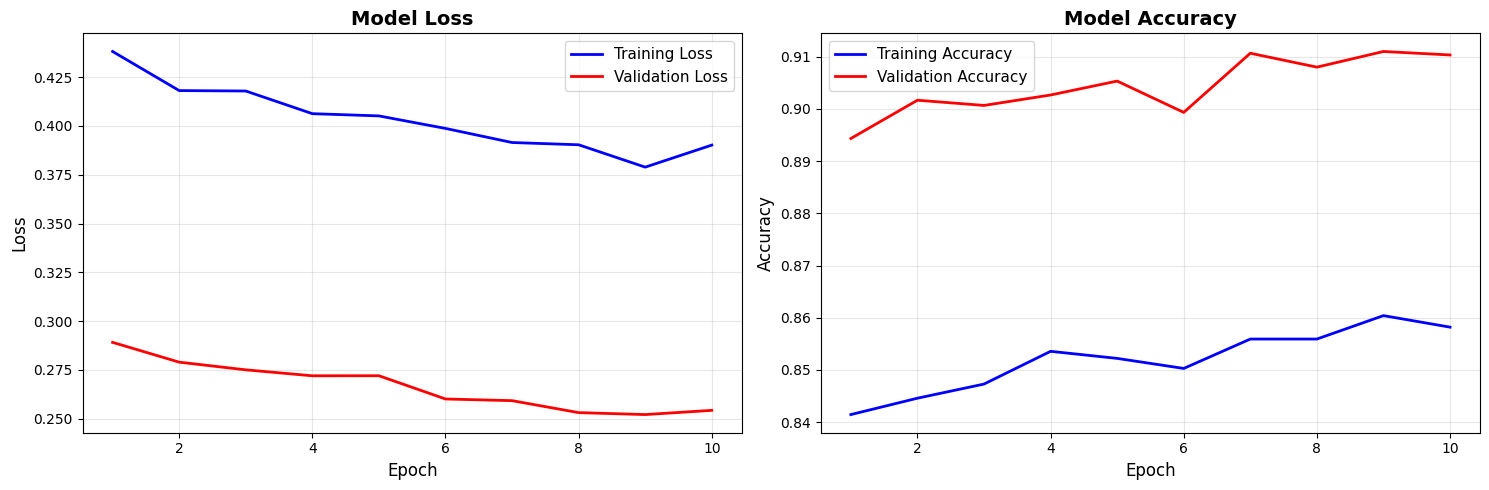

In [47]:
helper_utils.visualize_training_history(history_conv)
plt.show()

**Quick Check**: Visualize predictions

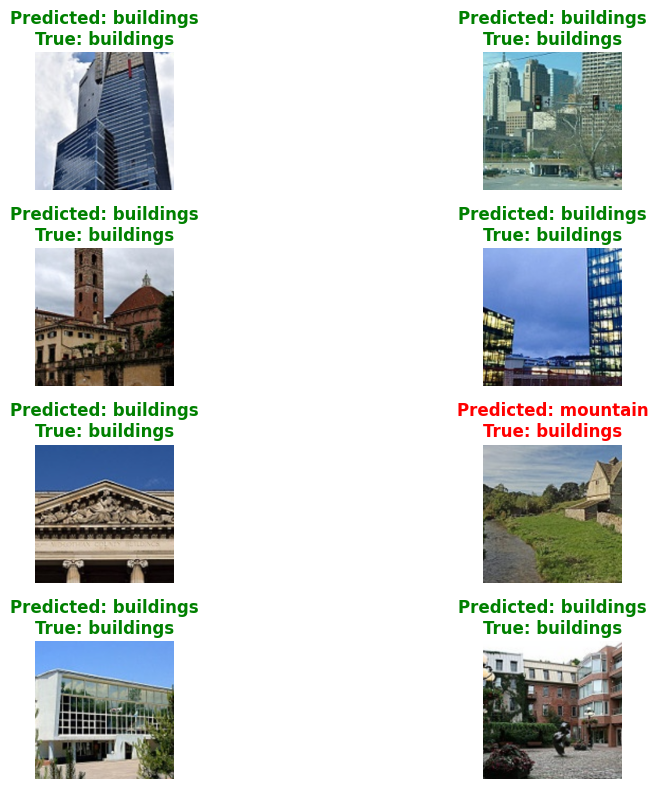

In [51]:
helper_utils.visualize_predictions(model_conv, dataloaders['val'], class_names, device, num_images=8)
plt.show()

<a name='4-2'></a>
### 4.2 Fine-tuning the ConvNet

In this approach, we unfreeze all layers and train the entire network with a smaller learning rate.

**Task:**

1. Load a fresh pre-trained model
2. Modify the final layer
3. Set up optimizer for all parameters with a smaller learning rate
4. Train the model

In [52]:
# YOUR CODE HERE
model_ft = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))  # 6 classes
model_ft = model_ft.to(device)

print(model_ft.fc)

Linear(in_features=512, out_features=6, bias=True)


In [53]:
# YOUR CODE HERE
criterion_ft = nn.CrossEntropyLoss()

In [54]:
# YOUR CODE HERE
optimizer_ft = torch.optim.SGD(
    model_ft.parameters(),   # all parameters will be updated here which is diff from the upper method where we are freezing the layes and changing the fc only
    lr=1e-4,
    momentum=0.9,
)

scheduler_ft = torch.optim.lr_scheduler.StepLR(
    optimizer_ft,
    step_size=7,
    gamma=0.1,
)


In [55]:
# YOUR CODE HERE
num_epochs_ft = 10

model_ft, history_ft = train_model(
    model_ft,
    dataloaders,
    criterion_ft,
    optimizer_ft,
    device,
    num_epochs=num_epochs_ft,
    scheduler=scheduler_ft,
)

Epoch 1/10
--------------------
train Loss: 0.9459  Acc: 0.7011
val Loss: 0.4312  Acc: 0.8817

Epoch 2/10
--------------------
train Loss: 0.5002  Acc: 0.8316
val Loss: 0.3050  Acc: 0.9043

Epoch 3/10
--------------------
train Loss: 0.4326  Acc: 0.8489
val Loss: 0.2648  Acc: 0.9110

Epoch 4/10
--------------------
train Loss: 0.3912  Acc: 0.8657
val Loss: 0.2468  Acc: 0.9153

Epoch 5/10
--------------------
train Loss: 0.3790  Acc: 0.8665
val Loss: 0.2293  Acc: 0.9173

Epoch 6/10
--------------------
train Loss: 0.3589  Acc: 0.8736
val Loss: 0.2238  Acc: 0.9227

Epoch 7/10
--------------------
train Loss: 0.3520  Acc: 0.8772
val Loss: 0.2202  Acc: 0.9240

Epoch 8/10
--------------------
train Loss: 0.3403  Acc: 0.8784
val Loss: 0.2193  Acc: 0.9240

Epoch 9/10
--------------------
train Loss: 0.3413  Acc: 0.8777
val Loss: 0.2162  Acc: 0.9250

Epoch 10/10
--------------------
train Loss: 0.3385  Acc: 0.8774
val Loss: 0.2197  Acc: 0.9257

Training complete 8m 46s
best val Acc: 0.9257


**Quick Check**: Visualize training history

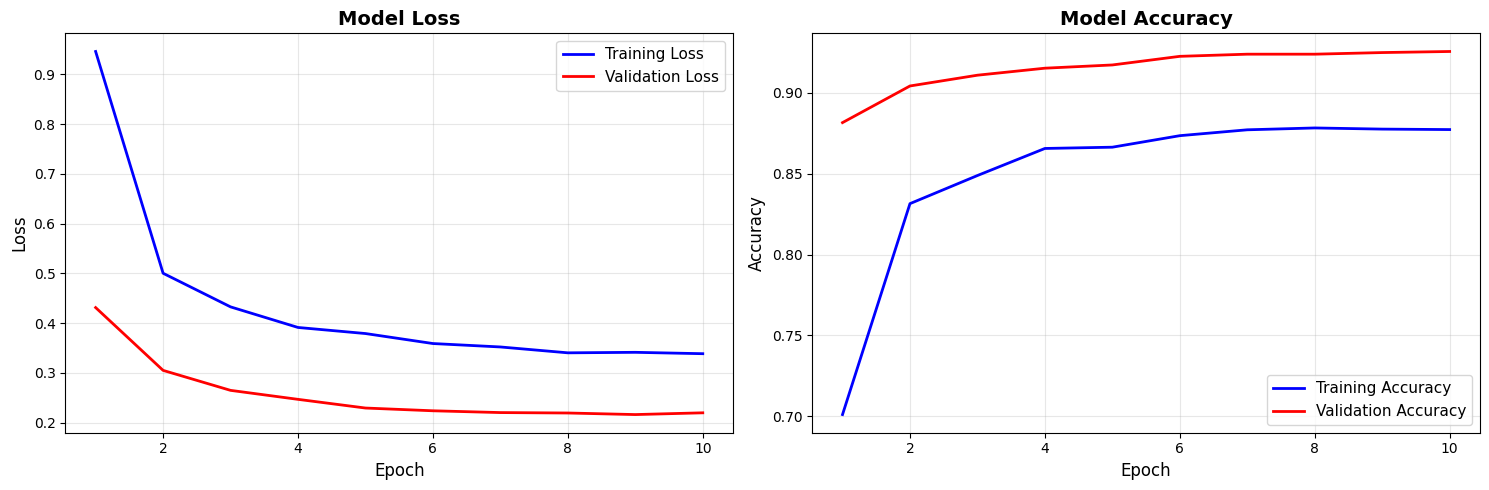

In [56]:
helper_utils.visualize_training_history(history_ft)
plt.show()

**Quick Check**: Visualize predictions

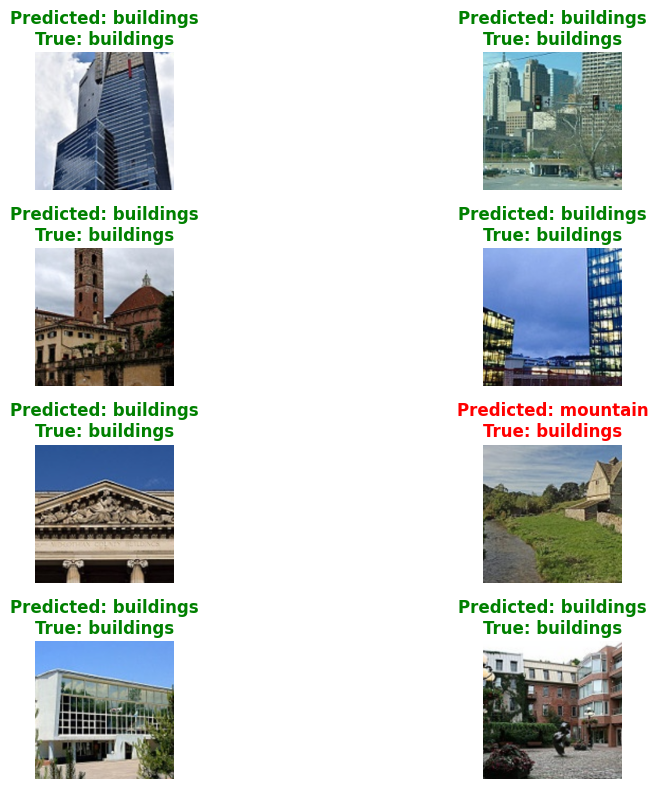

In [58]:
helper_utils.visualize_predictions(model_ft, dataloaders['val'], class_names, device, num_images=8)
plt.show()

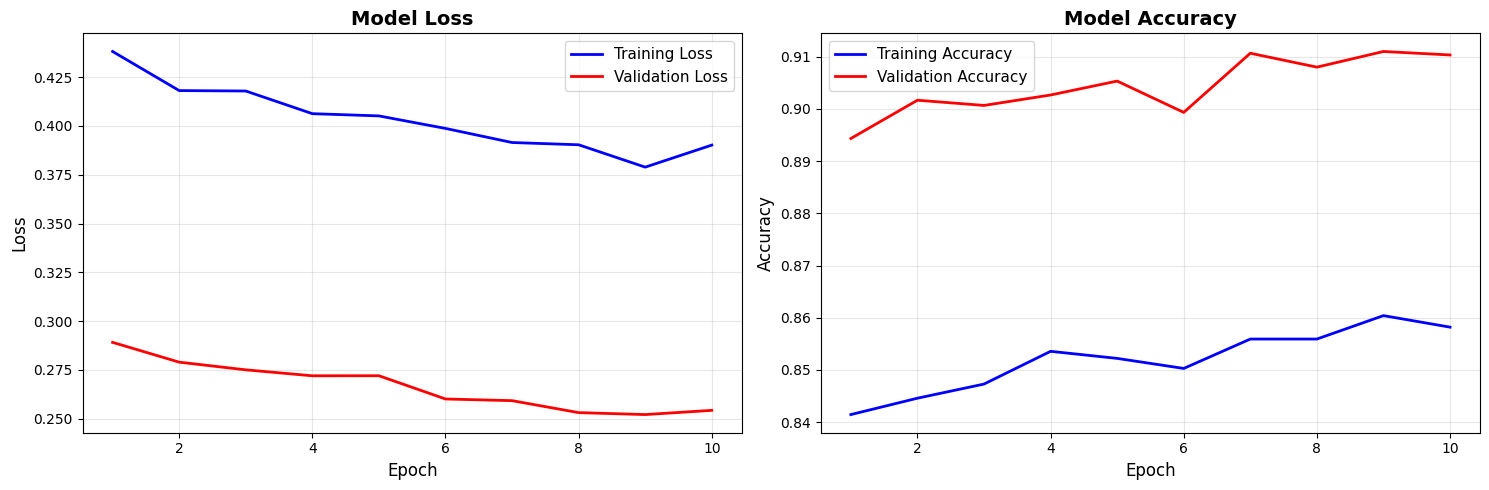

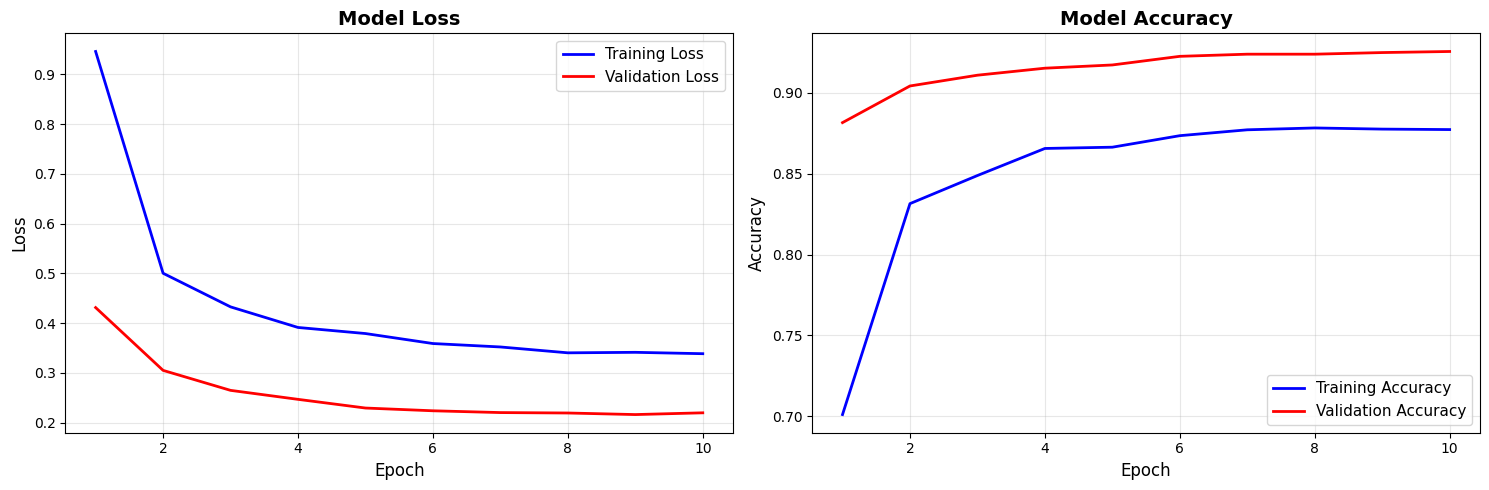

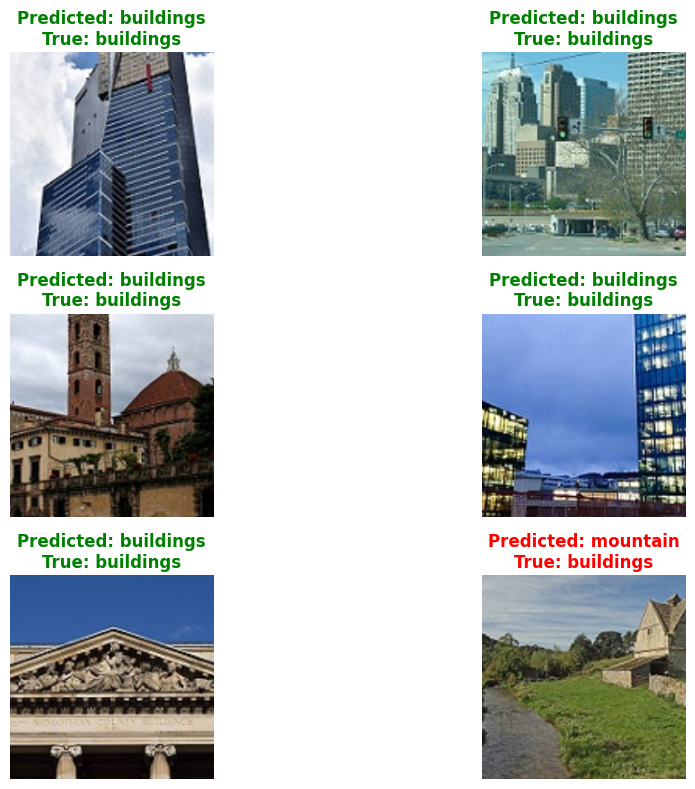

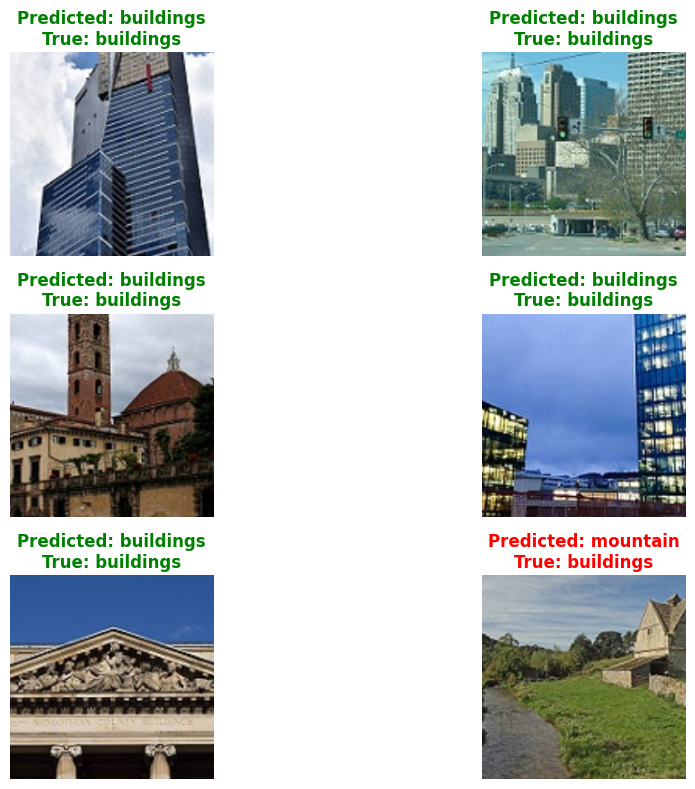

In [59]:
#just for me to compare
helper_utils.visualize_training_history(history_conv)
plt.show()

helper_utils.visualize_training_history(history_ft)
plt.show()

helper_utils.visualize_predictions(model_conv, dataloaders['val'], class_names, device, num_images=6)
plt.show()

helper_utils.visualize_predictions(model_ft, dataloaders['val'], class_names, device, num_images=6)
plt.show()


<a name='5'></a>
## 5. Evaluation

Compare the performance of both approaches.

**Task:** Evaluate both models and compare their performance metrics.

In [64]:
# Evaluate models on validation set
# YOUR CODE HERE
# Compare final validation accuracies, training times, etc.

# Print comparison
print("Feature Extractor Approach:")
print(f"  Best Val Accuracy: {max(history_conv['val_acc']):.4f}")
print(f"  Final Val Accuracy: {history_conv['val_acc'][-1]:.4f}")
print()
print("Fine-tuning Approach:")
print(f"  Best Val Accuracy: {max(history_ft['val_acc']):.4f}")
print(f"  Final Val Accuracy: {history_ft['val_acc'][-1]:.4f}")

Feature Extractor Approach:
  Best Val Accuracy: 0.9110
  Final Val Accuracy: 0.9103

Fine-tuning Approach:
  Best Val Accuracy: 0.9257
  Final Val Accuracy: 0.9257


<a name='6'></a>
## 6. Inference on Custom Images

Test your trained model on custom images.

**Task:** Load a custom image, preprocess it, and make a prediction using your trained model.

**Reference:** [Image Preprocessing](https://pytorch.org/vision/stable/transforms.html)

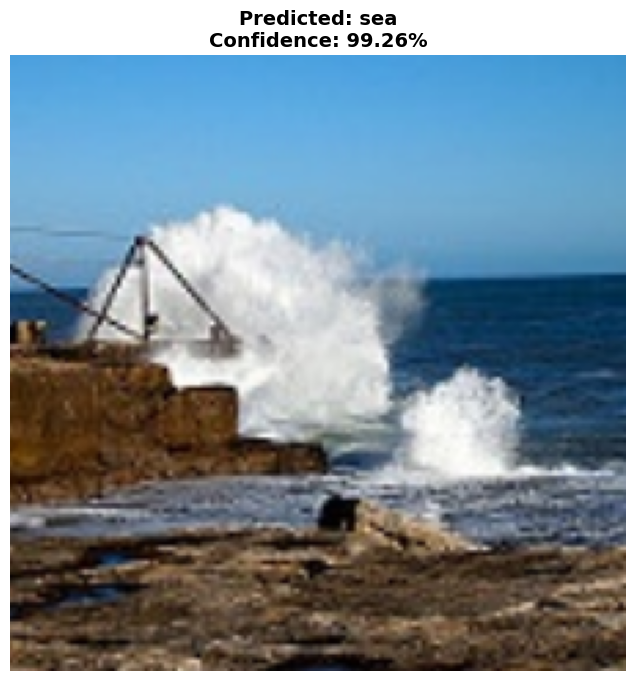

In [62]:
# Make prediction on a custom image
img_path = '/content/data/seg_test/seg_test/sea/20072.jpg'

# YOUR CODE HERE
# Use helper_utils.visualize_single_prediction or helper_utils.predict_single_image
helper_utils.visualize_single_prediction(
    model_ft,  # or model_conv
    img_path,
    data_transforms['val'],
    class_names,
    device
)
plt.show()

# 🏆🎉 Congratulations on completing the Weekly Final Project! 🎉🏆

Fantastic job on finishing the Weekly Final Project! You’ve put your skills to the test and made it to the end. Take a moment to celebrate your hard work and dedication. Keep up the great work and continue your learning journey!

<a name='7'></a>
## 7. Deployment (ONNX)

Convert your trained model to ONNX format for deployment.

**Task:**
1. Convert the PyTorch model to ONNX format
2. Load the ONNX model and perform inference

**Reference:**
- [PyTorch to ONNX](https://docs.pytorch.org/tutorials/beginner/onnx/export_simple_model_to_onnx_tutorial.html)

In [66]:
!pip install onnx onnxruntime onnxscript

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 122.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 124.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.4/693.4 kB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.4 MB/s eta 0:00:00


In [67]:
# Convert model to ONNX
# YOUR CODE HERE

# Set model to evaluation mode
model_ft.eval()

# Create dummy input (batch_size=1, channels=3, height=224, width=224)
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export to ONNX
onnx_path = 'model.onnx'
torch.onnx.export(
    model_ft,
    dummy_input,
    onnx_path,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)

print(f"Model exported to {onnx_path}")

/tmp/ipython-input-3126833882.py:12: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(


[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 40 of general pattern rewrite rules.
Model exported to model.onnx


In [73]:
# Load ONNX model and perform inference
# YOUR CODE HERE
import onnxruntime as ort
from PIL import Image
import numpy as np
# Load ONNX model
ort_session = ort.InferenceSession(onnx_path)

# Prepare input (use validation transform)
img_path = '/content/data/seg_test/seg_test/sea/20072.jpg'
img = Image.open(img_path).convert('RGB')
img_tensor = data_transforms['val'](img).unsqueeze(0)
img_numpy = img_tensor.numpy()

# Run inference
outputs = ort_session.run(None, {'input': img_numpy})
logits = outputs[0][0]
probs = np.exp(logits) / np.sum(np.exp(logits))
pred_class_idx = np.argmax(probs)
pred_class = class_names[pred_class_idx]
confidence = probs[pred_class_idx]

print(f"Predicted: {pred_class} (confidence: {confidence:.2%})")

Predicted: sea (confidence: 99.26%)
